In [36]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy   as np
import matplotlib.cm as cm
from scipy import stats
from ArcticTools import map
from ArcticTools import Topostrophy_sepecific_layer as Ts
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import glob

sns.set_style("whitegrid")
%matplotlib inline

In [18]:
# get basic variables
nav_lat= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['nav_lat'][:]
nav_lon= nc.Dataset('/ocean/xiaoxiny/research/data/isobath_factor.nc').variables['nav_lon'][:]
e3t= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['e3t_0'][0,:]

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
nemolon=bathy.variables['nav_lon'][400:,:]
nemolat=bathy.variables['nav_lat'][400:,:]
bathy=bathy.variables['Bathymetry'][400:,:]

tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
tmask=tmask.variables['tmask'][0,:,400:,:]

nclist=['/ocean/xiaoxiny/research/result_jasper/data_exh005_bt/EXH005-bt_19912016.nc',
        '/ocean/xiaoxiny/research/result_jasper/data_exh005_btscav_v2/EXH005-btscav_v2_19912016.nc',
       ]

with nc.Dataset('/ocean/xiaoxiny/research/data/data_factor.nc') as fac:
    fac = fac.variables['factor'][0,:,400:,:]

#### Preparation functions

In [19]:
# define basic data loading functions
def region(data,shallow,deep):
    # make slices
    TR_8b = np.copy(data)            ;TR_8i = np.copy(data)
    TR_8b[shallow == 0] = np.nan     ;TR_8i[deep == 0] = np.nan
    # domain average
    xb = np.nanmean(TR_8b)
    xi = np.nanmean(TR_8i)
    return xb,xi

def load_tracer(ptrc,layer, string):
    '''eg. layer = 30, string = 'TR_8'''
    data = ptrc.variables[string][:,layer,...]
    return data

def load_depth(ptrc):
    data = ptrc.variables['deptht'][:]
    return data
#test done - dep = load_depth(ptrc=nc.Dataset(nclist[1]))

# define region
def section(x0,y0,length,xi,yi):
    '''xi = 1 then x0-i
          = 0 then x0=i
    same for yi'''
    a=[]
    b=[]
    for i in range (length):
        a.append(n_lon[x0+xi*i,y0+yi*i])
        b.append(n_lat[x0+xi*i,y0+yi*i])
    return np.array(a),np.array(b)

def section_trc(x0,y0,length,xi,yi,starting_year, trc_input):
    '''xi = 1 then x0-i
          = 0 then x0=i
    same for yi
    
    trc_input = TR_8 , layer should have been handeled by now'''
    a=[]
    for i in range (length):
        a.append(trc_input[starting_year - 1991 + 1 :,x0+xi*i,y0+yi*i])
    return np.array(a)

In [20]:
# functions newly defined on Nov 24 - for getting u,v values along the imaginal line in the internal Arctic

def vel(keyword,T,ENG):
    """'design to obtain velocity field
    T: year, value: eg. 2002
    'ENG': string, can be ENG3,EXH001 or EXH005
    """
    if keyword =='U':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s.nc'%(ENG,T)))
        uvel=nc.Dataset(nc_filename[0])
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    elif keyword =='V':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s.nc'%(ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*W*%s.nc'%(ENG,T)))
        wvel=nc.Dataset(nc_filename[0])
        data =wvel.variables['vovecrtz'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

def vel_across_imaginary_line(layer,length,x0,y0,xi,yi,ENG='EXH005',endyear = 2015):
    '''aross section vel'''
    a=np.empty([length]);

    signx=xi;signy=yi
    zi=(yi**2+xi**2)**0.5
    yearnum = endyear - 2002 + 1 
    # +1 is just to compensate the starting year. eg endyear = 2003, yearnum = 2 
    val=np.empty([yearnum,length]);
    for j in range (yearnum):
        u=vel(keyword='U',T=2002+j,ENG=ENG)[layer,:,:]
        v=vel(keyword='V',T=2002+j,ENG=ENG)[layer,:,:]

        for i in range (length):
                temp=-u[x0+signx*i,y0+signy*i]*yi/zi+v[x0+signx*i,y0+signy*i]*xi/zi
                temp=np.ma.masked_where(tmask[layer,x0+signx*i,y0+signy*i]<=0,temp)
                a[i]=temp
        val[j,:]=a[:]
    return val

# Test done: v = vel_across_imaginary_line(layer=30,x0=195,y0=225,length=70,xi=1.5,yi=1.,ENG='EXH005')

#### T_mix 

In [21]:
def boundarysource(xp,dz,sink):
    '''xp should contain three elements: xp(z-1),xp(z),xp(z+1)'''
    '''sink should contain three elements: sinking (z-1), z, (z+1)'''
    sb = ((sink[0]*xp[0]) - (sink[2]* xp[2]))/dz
    return sb


def advection(xtotal,a,b,paramx0,paramy0):
    '''u*trc*dy following the scatter line'''
    '''Unit: dmp/y'''
    # a/b_front/back have been defined in an upper cell
    dy = np.zeros_like(a)
    dy[:-1] = ((a[1:]-a[:-1])**2+(b[1:]-b[:-1])**2)**0.5
    dy[-1] = dy[-2]# approximation for the last dy
    
    # Obatin velocity along the line
    u  = vel_across_imaginary_line(layer=30,x0=paramx0,y0=paramy0,length=70,xi=1.5,yi=1.,ENG='EXH005')
    # calculate dtrc; dtrc dimension: [t,i,j]
    trc= section_trc(x0=195,y0=225,length=70,xi=1.5,yi=1.,starting_year = 2002, trc_input=xtotal)
    
    # just to make sure the dimension shape is consistent with u - which's loaded from a function built in a while ago back in 2017
    trc = trc.T
    
    dtrc = np.zeros_like(trc)
    
    adv = []
    for t in range (len(dtrc[:,0])):
        adv.append(u[t,:]*trc[t,:]*dy)
        
    adv_deep = np.array(adv)[:,10:50] # index: please refer to calculation in mask_boundary and mask_internal
    adv_bc1 = np.array(adv)[:,:10];adv_bc2 = np.array(adv)[:,-20:];adv_bc = np.hstack((adv_bc1,adv_bc2))
    #print (u,dy)
    
    return np.nansum(np.array(adv_deep),axis=1)*365*24*3600,\
           np.nansum(np.array(adv_bc),axis=1)*365*24*3600

    
with nc.Dataset('/ocean/xiaoxiny/research/data/data_factor0.nc') as fac0:
    fac0 = fac0.variables['factor0'][0,:,400:,:]
iceinput = nc.Dataset(nclist[1]).variables['TR_12'][:]     
Ice_from_predifinelastlayer=np.zeros_like(iceinput[:,0,:,:])
for depth in range (len(fac0[:,0,0])):
    print (">>> reaching 50%") if (depth == len(fac0[:,0,0])/2) else None
    for i in range (len(fac0[0,:,0])):
        for j in range (len(fac0[0,0,:])):
            if fac0[depth,i,j]==1:
                for t in range (len(iceinput[:,0,0,0])):
                    Ice_from_predifinelastlayer[t,i,j]=iceinput[t,depth,i,j]
                    
                    
def callsinking(ice0,Ice_from_predifinelastlayer,fac):
    "s0 = normal sinking; also consider enhanced sinking if within the enhanced layer - delta_s = enhanced sinking"
    s0=-1387*np.array(ice0)+1874
    s_from_predifinelastlayer=-1387*np.array(Ice_from_predifinelastlayer)+1874
    deltas=np.zeros_like(s0)
    s     =np.zeros_like(s0)
    for t in range (len(ice0[:,0,0])):
        for i in range (len(ice0[0,:,0])):
            for j in range (len(ice0[0,0,:])):
                if Ice_from_predifinelastlayer[t,i,j]> 0.75: 
                    # nemo
                    deltas[t,i,j] = (1-3*(Ice_from_predifinelastlayer[t,i,j]))*s_from_predifinelastlayer[t,i,j]
                else:
                    deltas[t,i,j] = 1874 - s0[t,i,j]
        s[t,:,:] = s0[t,:,:] + deltas[t,:,:]*fac  
    return s    
    
def tmix(xb,xi,xbt,dt,xp,dz,sink,adv,box):
    '''
       
       xb_t: should contain two elements: x(t-1), x(t+1)
       dt: time step (default is 2 year)
       
       spatials are all in centre difference/ temporaries are all in forward difference'''
    Q = 0.0267
    s  = boundarysource(xp,dz,sink)
    if box == 'boundary':
        dtrc_dt = (xb - xbt)/dt
        A = 5.7*1e11 #m2
    if box == 'internal':
        xit = xbt # renaming just to avoid confusion
        dtrc_dt = (xi - xit)/dt
        A = 9.5*1e11 #m2
    # coefficient - cell 25 & Area%20of%20deep%20and%20shallow%20regions%20in%20CB.ipynb

    '''tmix    = A*dz*(xi-xb)/(A*dz*dtrc_dt - A*dz*Q - A*dz*s - adv*dz), dz cancels out'''
    tmix    = A*(xi-xb)/(A*dtrc_dt - A*Q - A*s - adv) 
    
    return tmix,A*s,A*dtrc_dt,adv

>>> reaching 50%


In [22]:
# visualization
def Tmix4_layers(Layer,box,shallow,deep,a,b,paramx0,paramy0,analysis_mode="off"):
    k = 0
    tmixing ={'layer1':[],'layer2':[],'layer3':[],'layer4':[]}
    for i,tarray in zip (range (len(Layer)),[tmixing['layer1'],tmixing['layer2'],\
                                                         tmixing['layer3'],tmixing['layer4']]):
        
        layer = Layer[i];
        if analysis_mode !="off":
            # only plot the 500m layer 
            if i ==2:
                f_,ax_=plt.subplots(4,figsize = (8,6),sharex=True);
                f_.suptitle("Analysis mode: region - %s"%box, fontsize="x-large")
                mycolors = cm.Spectral(np.linspace(0, 1, 6))
        #print('>> working on :%s m'%dep[layer])
        '''prepare data'''
        TR_8  = load_tracer(nc.Dataset(nclist[1]),layer = layer, string = 'TR_8')\
              + load_tracer(nc.Dataset(nclist[1]),layer = layer, string = 'TR_10')
        TR_10_upperlayer = load_tracer(nc.Dataset(nclist[1]),layer = layer-1, string = 'TR_10')
        TR_10_currentlayer = load_tracer(nc.Dataset(nclist[1]),layer = layer, string = 'TR_10')
        TR_10_lowerlayer = load_tracer(nc.Dataset(nclist[1]),layer = layer+1, string = 'TR_10')


        TR_12_upperlayer = load_tracer(nc.Dataset(nclist[1]),layer = layer-1, string = 'TR_12')
        TR_12_currentlayer = load_tracer(nc.Dataset(nclist[1]),layer = layer, string = 'TR_12')
        TR_12_lowerlayer = load_tracer(nc.Dataset(nclist[1]),layer = layer+1, string = 'TR_12')
        
        sink_upperlayer = callsinking(TR_12_upperlayer,Ice_from_predifinelastlayer=Ice_from_predifinelastlayer,fac=fac[layer-1,...] )
        sink_currentlayer = callsinking(TR_12_currentlayer,Ice_from_predifinelastlayer=Ice_from_predifinelastlayer,fac=fac[layer,...] )
        sink_lowerlayer = callsinking(TR_12_lowerlayer,Ice_from_predifinelastlayer=Ice_from_predifinelastlayer,fac=fac[layer+1,...] )
        
        trcadv_deep,trcadv_bc = advection(xtotal=TR_8,a=a,b=b,paramx0=paramx0,paramy0=paramy0)
        
        for data in [TR_8,TR_10_upperlayer,TR_10_currentlayer,TR_10_lowerlayer,TR_12_upperlayer,TR_12_currentlayer,TR_12_lowerlayer]:
            data[data<=0] = np.nan

        for t in range (2002,2015):
            '''dtrc/dt'''
            xb,xi = region(TR_8[t-1991+1,:,:],shallow, deep)
            xbt,xit = region(TR_8[t-1991-1,:,:],shallow, deep)

            dt = np.array([2]) # unit: yr
            '''s'''
            dz = e3t[layer]

            xpbc = [];xpin=[]
            for data in [TR_10_upperlayer[t-1991,:,:],TR_10_currentlayer[t-1991,:,:],TR_10_lowerlayer[t-1991,:,:]]:
                bc_xp,in_xp = region(data,shallow, deep)
                xpbc.append(bc_xp);xpin.append(in_xp)
            xpbc = np.array(xpbc);xpin = np.array(xpin)

            sinkbc = [];sinkin = []
            for data in [sink_upperlayer[t-1991,:,:],sink_currentlayer[t-1991,:,:],sink_lowerlayer[t-1991,:,:]]:
                sink_bc,sink_in = region(data,shallow, deep)
                sinkbc.append(sink_bc);sinkin.append(sink_in)
            
            '''adv'''
            adv_deep,adv_bc = trcadv_deep[t-2002],trcadv_bc[t-2002]
            
            '''T mix'''
            if box == 'boundary':
                sink=sinkbc
                mixing_ts,s,dtrc_dt,advSum = tmix(xb,xi,xbt,dt,xpbc,dz,sink,adv_bc,box)
            if box == 'internal':
                sink=sinkin
                mixing_ts,s,dtrc_dt,advSum = tmix(xb,xi,xit,dt,xpin,dz,sink,adv_deep,box)
            tarray.append(mixing_ts)
            if analysis_mode !="off":
                # only plot the 500m layer 
                if i ==2:
                    [myax.scatter(t,data,c=c) for myax,data,c in zip(ax_,[dtrc_dt,-s,advSum,xi-xb],mycolors)]
                    [myax.plot([2002,2016],[0,0],'k') for myax in ax_[:] ]
                    [myax.set_xlim([2002,2015]) for myax in ax_ ]
                    [myax.set_title(label) for myax,label in zip(ax_,['dtrc_dt','s','adv','xi-xb']) ]
    return tmixing

#### two regions

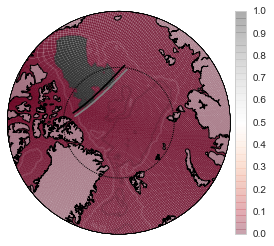

In [23]:
shallow=np.load("shallow.npy")
deep3=np.load("deep.npy")
m = Basemap(projection='npstere',boundinglat=70,lon_0=0,resolution='l',round="True")
n_lon,n_lat = m(nemolon,nemolat)
m.pcolor(n_lon,n_lat, np.ma.masked_invalid(deep3), cmap = 'RdGy',alpha = 0.2)
m.colorbar()
m.drawcoastlines()
m.fillcontinents(color = '0.85',alpha=0.5)
m.drawparallels(np.arange(-90.,90.,20.),labels=[0, 0, 0, 0])
m.contour(n_lon,n_lat,bathy,[1000,3000],alpha=0.1)

#Cross-Arctic section 
a_front,b_front=section(x0=195,y0=225,length=70,xi=1.5,yi=1.)
m.plot(a_front[::5],b_front[::5],color='black')

a_mid,b_mid=section(x0=190,y0=230,length=70,xi=1.5,yi=1.)
m.plot(a_mid[::5],b_mid[::5],color='grey')

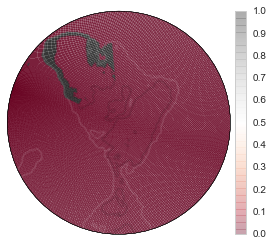

In [26]:
ind = (shallow!=1);shallow[ind]=0
m.pcolor(n_lon,n_lat, np.ma.masked_invalid(shallow), cmap = 'RdGy',alpha = 0.2)
m.colorbar()
m.contour(n_lon,n_lat,bathy,[1000,3000],alpha=0.1)

In [25]:
e2u= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['e2u'][0,400:,:]
e2v= nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc').variables['e2v'][0,400:,:]
print ("A_shallow: ",np.nansum(shallow*e2u*e2v), "A_deep: ",np.nansum(deep*e2u*e2v))

A_shallow:  575724914734.0 A_deep:  953344429912.0


### Analysis mode on - Tmix calculated based on Th

- grey line

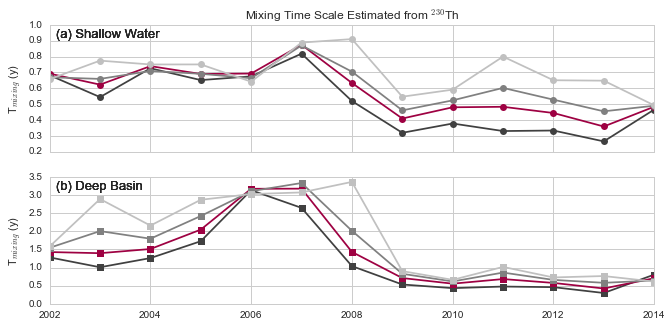

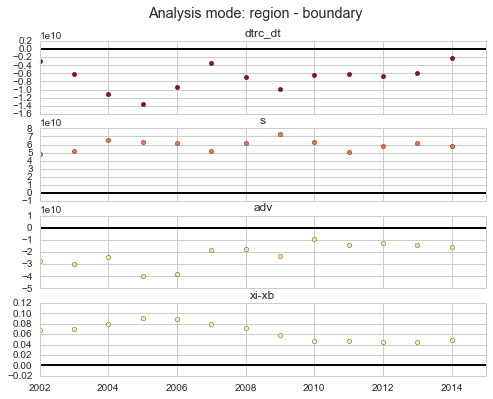

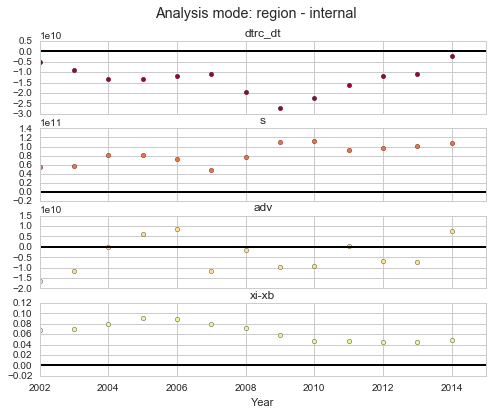

In [16]:
dep = load_depth(ptrc=nc.Dataset(nclist[1]))

colors = cm.gray(np.linspace(0, 1, 5))
colors = np.array([colors[1],cm.Spectral(np.linspace(0, 1, 7))[0],colors[2],colors[3]])
f,axes = plt.subplots(2,1,figsize = (13/1.2,6/1.2),sharex=True)

ax=axes[0]
tmixing = Tmix4_layers([29,30,31,33],box='boundary',shallow=shallow,deep=deep3,\
                       a=a_back,b=b_back,paramx0=190,paramy0=230,analysis_mode="on")
for tarray,c in zip ([tmixing['layer1'],tmixing['layer2'],tmixing['layer3'],tmixing['layer4']],\
                           colors):

        ax.plot(np.linspace(2002,2014,13),tarray,'-o',c=c)
        ax.set_ylabel('T$_{mixing}$ (y)');
        #ax.set_ylim([0,3])
        plt.legend(loc=3,bbox_to_anchor=(-0.13,-0.5),ncol=4, frameon=False)
        ax.set_title('Mixing Time Scale Estimated from $^{230}$Th')
        ax.text(0.01,0.9, '%s %s'%('(a)','Shallow Water'), \
                    transform=ax.transAxes, ha='left', fontsize=13)
    
ax=axes[1]        
tmixing_d = Tmix4_layers([29,30,31,32],box='internal',shallow=shallow,deep=deep3,\
                         a=a_back,b=b_back,paramx0=190,paramy0=230,analysis_mode="on")
for tarray,c,layer in zip ([tmixing_d['layer1'],tmixing_d['layer2'],tmixing_d['layer3'],tmixing_d['layer4']],\
                           colors,[dep[29],round(dep[30]/10)*10,round(dep[31]/10)*10,round(dep[32]/10)*10]):
        ax.plot(np.linspace(2002,2014,13),tarray,'-s',c=c,label='Depth: %s m'%(np.int(layer)))
        plt.xlabel('Year');ax.set_ylabel('T$_{mixing}$ (y)')
        plt.legend(loc=3,bbox_to_anchor=(0.1,-0.5),ncol=4, frameon=False)
        ax.text(0.01,0.9, '%s %s'%('(b)','Deep Basin'), \
                    transform=ax.transAxes, ha='left', fontsize=13)
        
        #ax.set_ylim([0,8])

- black line

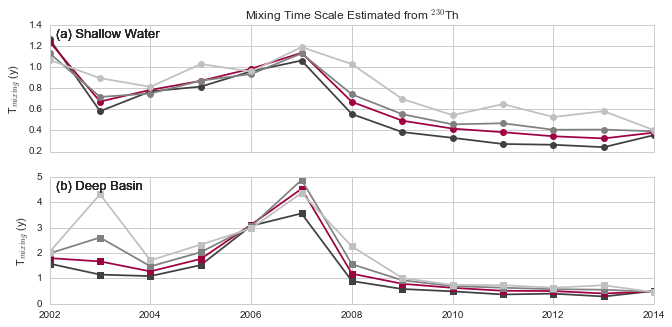

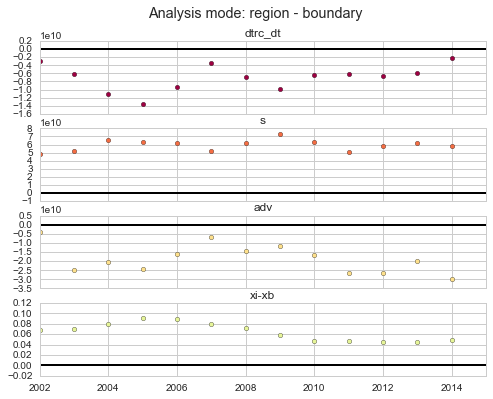

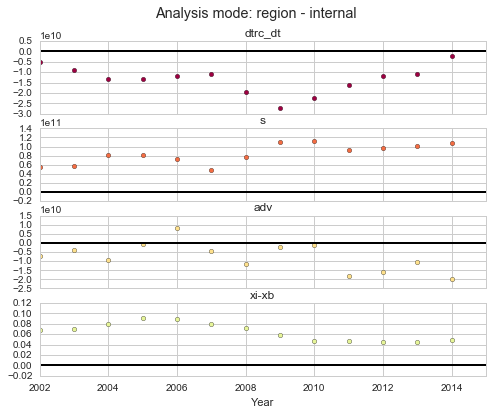

In [17]:
dep = load_depth(ptrc=nc.Dataset(nclist[1]))

colors = cm.gray(np.linspace(0, 1, 5))
colors = np.array([colors[1],cm.Spectral(np.linspace(0, 1, 7))[0],colors[2],colors[3]])
f,axes = plt.subplots(2,1,figsize = (13/1.2,6/1.2),sharex=True)

ax=axes[0]
tmixing = Tmix4_layers([29,30,31,33],box='boundary',shallow=shallow,deep=deep3,\
                       a=a_back,b=b_back,paramx0=195,paramy0=225,analysis_mode="on")
for tarray,c in zip ([tmixing['layer1'],tmixing['layer2'],tmixing['layer3'],tmixing['layer4']],\
                           colors):

        ax.plot(np.linspace(2002,2014,13),tarray,'-o',c=c)
        ax.set_ylabel('T$_{mixing}$ (y)');
        #ax.set_ylim([0,3])
        plt.legend(loc=3,bbox_to_anchor=(-0.13,-0.5),ncol=4, frameon=False)
        ax.set_title('Mixing Time Scale Estimated from $^{230}$Th')
        ax.text(0.01,0.9, '%s %s'%('(a)','Shallow Water'), \
                    transform=ax.transAxes, ha='left', fontsize=13)
    
        

ax=axes[1]
tmixing_d = Tmix4_layers([29,30,31,32],box='internal',shallow=shallow,deep=deep3,\
                         a=a_back,b=b_back,paramx0=195,paramy0=225,analysis_mode="on")
for tarray,c,layer in zip ([tmixing_d['layer1'],tmixing_d['layer2'],tmixing_d['layer3'],tmixing_d['layer4']],\
                           colors,[dep[29],round(dep[30]/10)*10,round(dep[31]/10)*10,round(dep[32]/10)*10]):
        ax.plot(np.linspace(2002,2014,13),tarray,'-s',c=c,label='Depth: %s m'%(np.int(layer)))
        plt.xlabel('Year');ax.set_ylabel('T$_{mixing}$ (y)')
        plt.legend(loc=3,bbox_to_anchor=(0.1,-0.5),ncol=4, frameon=False)
        ax.text(0.01,0.9, '%s %s'%('(b)','Deep Basin'), \
                    transform=ax.transAxes, ha='left', fontsize=13)
        
        #ax.set_ylim([0,8])